In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import shap
from datetime import datetime

In [3]:
working_with_dummies = True
use_StratifiedKFold = True

In [4]:
trn_dataset_with_preprocessing_path = r'../utilfiles/train_test_val_files/train_set_noNulls.csv'
val_dataset_with_preprocessing_path = r'../utilfiles/train_test_val_files/val_set_noNulls.csv'
test_dataset_with_preprocessing_path = r'../utilfiles/train_test_val_files/test_set_noNulls.csv'


trn_dataset_with_dummies_path = r'../utilfiles/train_test_val_files/train_set_with_dummies.csv'
val_dataset_with_dummies_path = r'../utilfiles/train_test_val_files/val_set_with_dummies.csv'
test_dataset_with_dummies_path = r'../utilfiles/train_test_val_files/test_set_with_dummies.csv'


if(working_with_dummies):
    trn_file_path = trn_dataset_with_dummies_path
    val_file_path = val_dataset_with_dummies_path
    test_file_path = test_dataset_with_dummies_path
else:
    trn_file_path = trn_dataset_with_preprocessing_path
    val_file_path = val_dataset_with_preprocessing_path
    test_file_path = test_dataset_with_preprocessing_path

In [5]:
# y_train = pd.read_csv(trn_file_path,usecols=['target'])['target']

In [6]:
full_train_df = pd.read_csv(trn_file_path)

In [7]:
reduced_train_df = full_train_df.sample(frac=0.6, random_state=42)

In [8]:
del full_train_df

In [9]:
y_train = reduced_train_df['target']


In [10]:
# params = {
#     'subsample': 0.7,
#     'reg_lambda': 1,
#     'reg_alpha': 0.1,
#     'n_estimators': 400,
#     'min_child_weight': 3,
#     'max_depth': 9,
#     'gamma': 0.3,
#     'eta': 0.01,
#     'colsample_bytree': 0.9
# }
params = {
    # 'n_estimators': 400,
    'max_depth' : 9,
    # 'eta' : 0.001,
    'learning_rate': 0.0025,
    'subsample': 0.9,
    'colsample_bytree': 0.6,
    # 'gamma' : 3,
    'min_child_weight' : 3,
    'reg_alpha' : 0.8,
    'reg_lambda' : 2,
    'scale_pos_weight': (len(y_train)-sum(y_train)) / sum(y_train),
    # 'early_stopping_rounds': 10,
    'eval_metric': 'auc'
}

In [11]:
current_year = datetime.now().year
reduced_train_df['age'] = current_year - reduced_train_df['34-0.0']

In [12]:
reduced_train_df.drop(columns=['eid', 'target', '34-0.0', 'Unnamed: 0'], inplace=True)
X_train = reduced_train_df
feature_names = X_train.columns.to_list()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
del reduced_train_df


In [13]:
# full_val_df = pd.read_csv(val_file_path)
# y_validation = full_val_df['target']
# full_val_df.drop(columns=['eid', 'target'], inplace=True)
# X_validation = full_val_df
# dvalid = xgb.DMatrix(X_validation, label=y_validation)
# del full_val_df

In [14]:
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [15]:
y_pred_proba = model.predict(dtrain)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

youdens_j = tpr -fpr
optimal_idx = np.argmax(youdens_j)
optimal_threshold = thresholds[optimal_idx]

threshold = optimal_threshold

Train


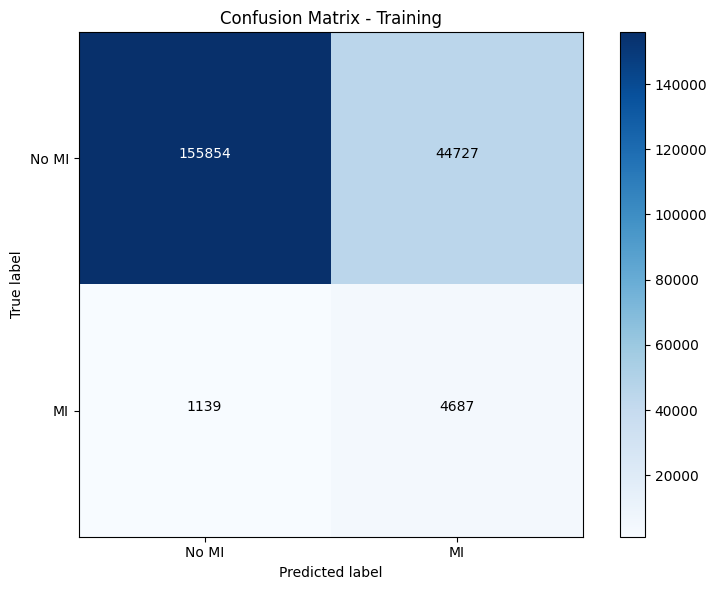

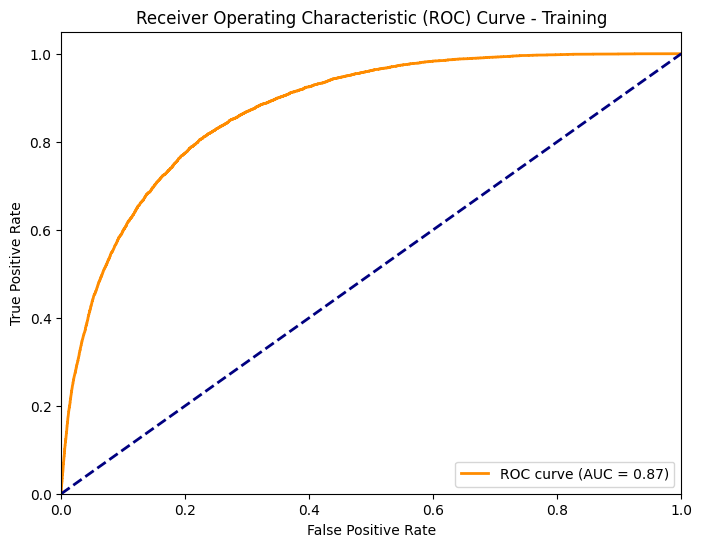

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    200581
           1       0.09      0.80      0.17      5826

    accuracy                           0.78    206407
   macro avg       0.54      0.79      0.52    206407
weighted avg       0.97      0.78      0.85    206407

[[155854  44727]
 [  1139   4687]]


In [16]:
# # Evaluate the model validation
# print(f"Validation")
# # Make predictions
# y_pred_proba = model.predict(dvalid)
# y_pred = [1 if y > threshold else 0 for y in y_pred_proba]

# # Confusion Matrix
# cm = confusion_matrix(y_validation, y_pred)
# plt.figure(figsize=(8, 6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Validation')
# plt.colorbar()
# tick_marks = np.arange(2)
# plt.xticks(tick_marks, ['No MI', 'MI'])
# plt.yticks(tick_marks, ['No MI', 'MI'])
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
# plt.tight_layout()
# plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_validation, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Validation')
# plt.legend(loc="lower right")
# plt.show()

# print(classification_report(y_true=y_validation,y_pred=y_pred))
# print(cm)

# Evaluate the model train
print(f"Train")
# Make predictions
y_pred_proba = model.predict(dtrain)
y_pred = [1 if y > threshold else 0 for y in y_pred_proba]

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Training')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No MI', 'MI'])
plt.yticks(tick_marks, ['No MI', 'MI'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training')
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_true=y_train,y_pred=y_pred))
print(cm)


## ***Test***

In [17]:
del dtrain

In [21]:
full_test_df = pd.read_csv(test_file_path)
current_year = datetime.now().year
full_test_df['age'] = current_year - full_test_df['34-0.0']

In [22]:
y_test = full_test_df['target']
full_test_df.drop(columns=['eid', 'target', '34-0.0', 'Unnamed: 0'], inplace=True)
X_test = full_test_df
dtest = xgb.DMatrix(X_test, label=y_test)
del full_test_df

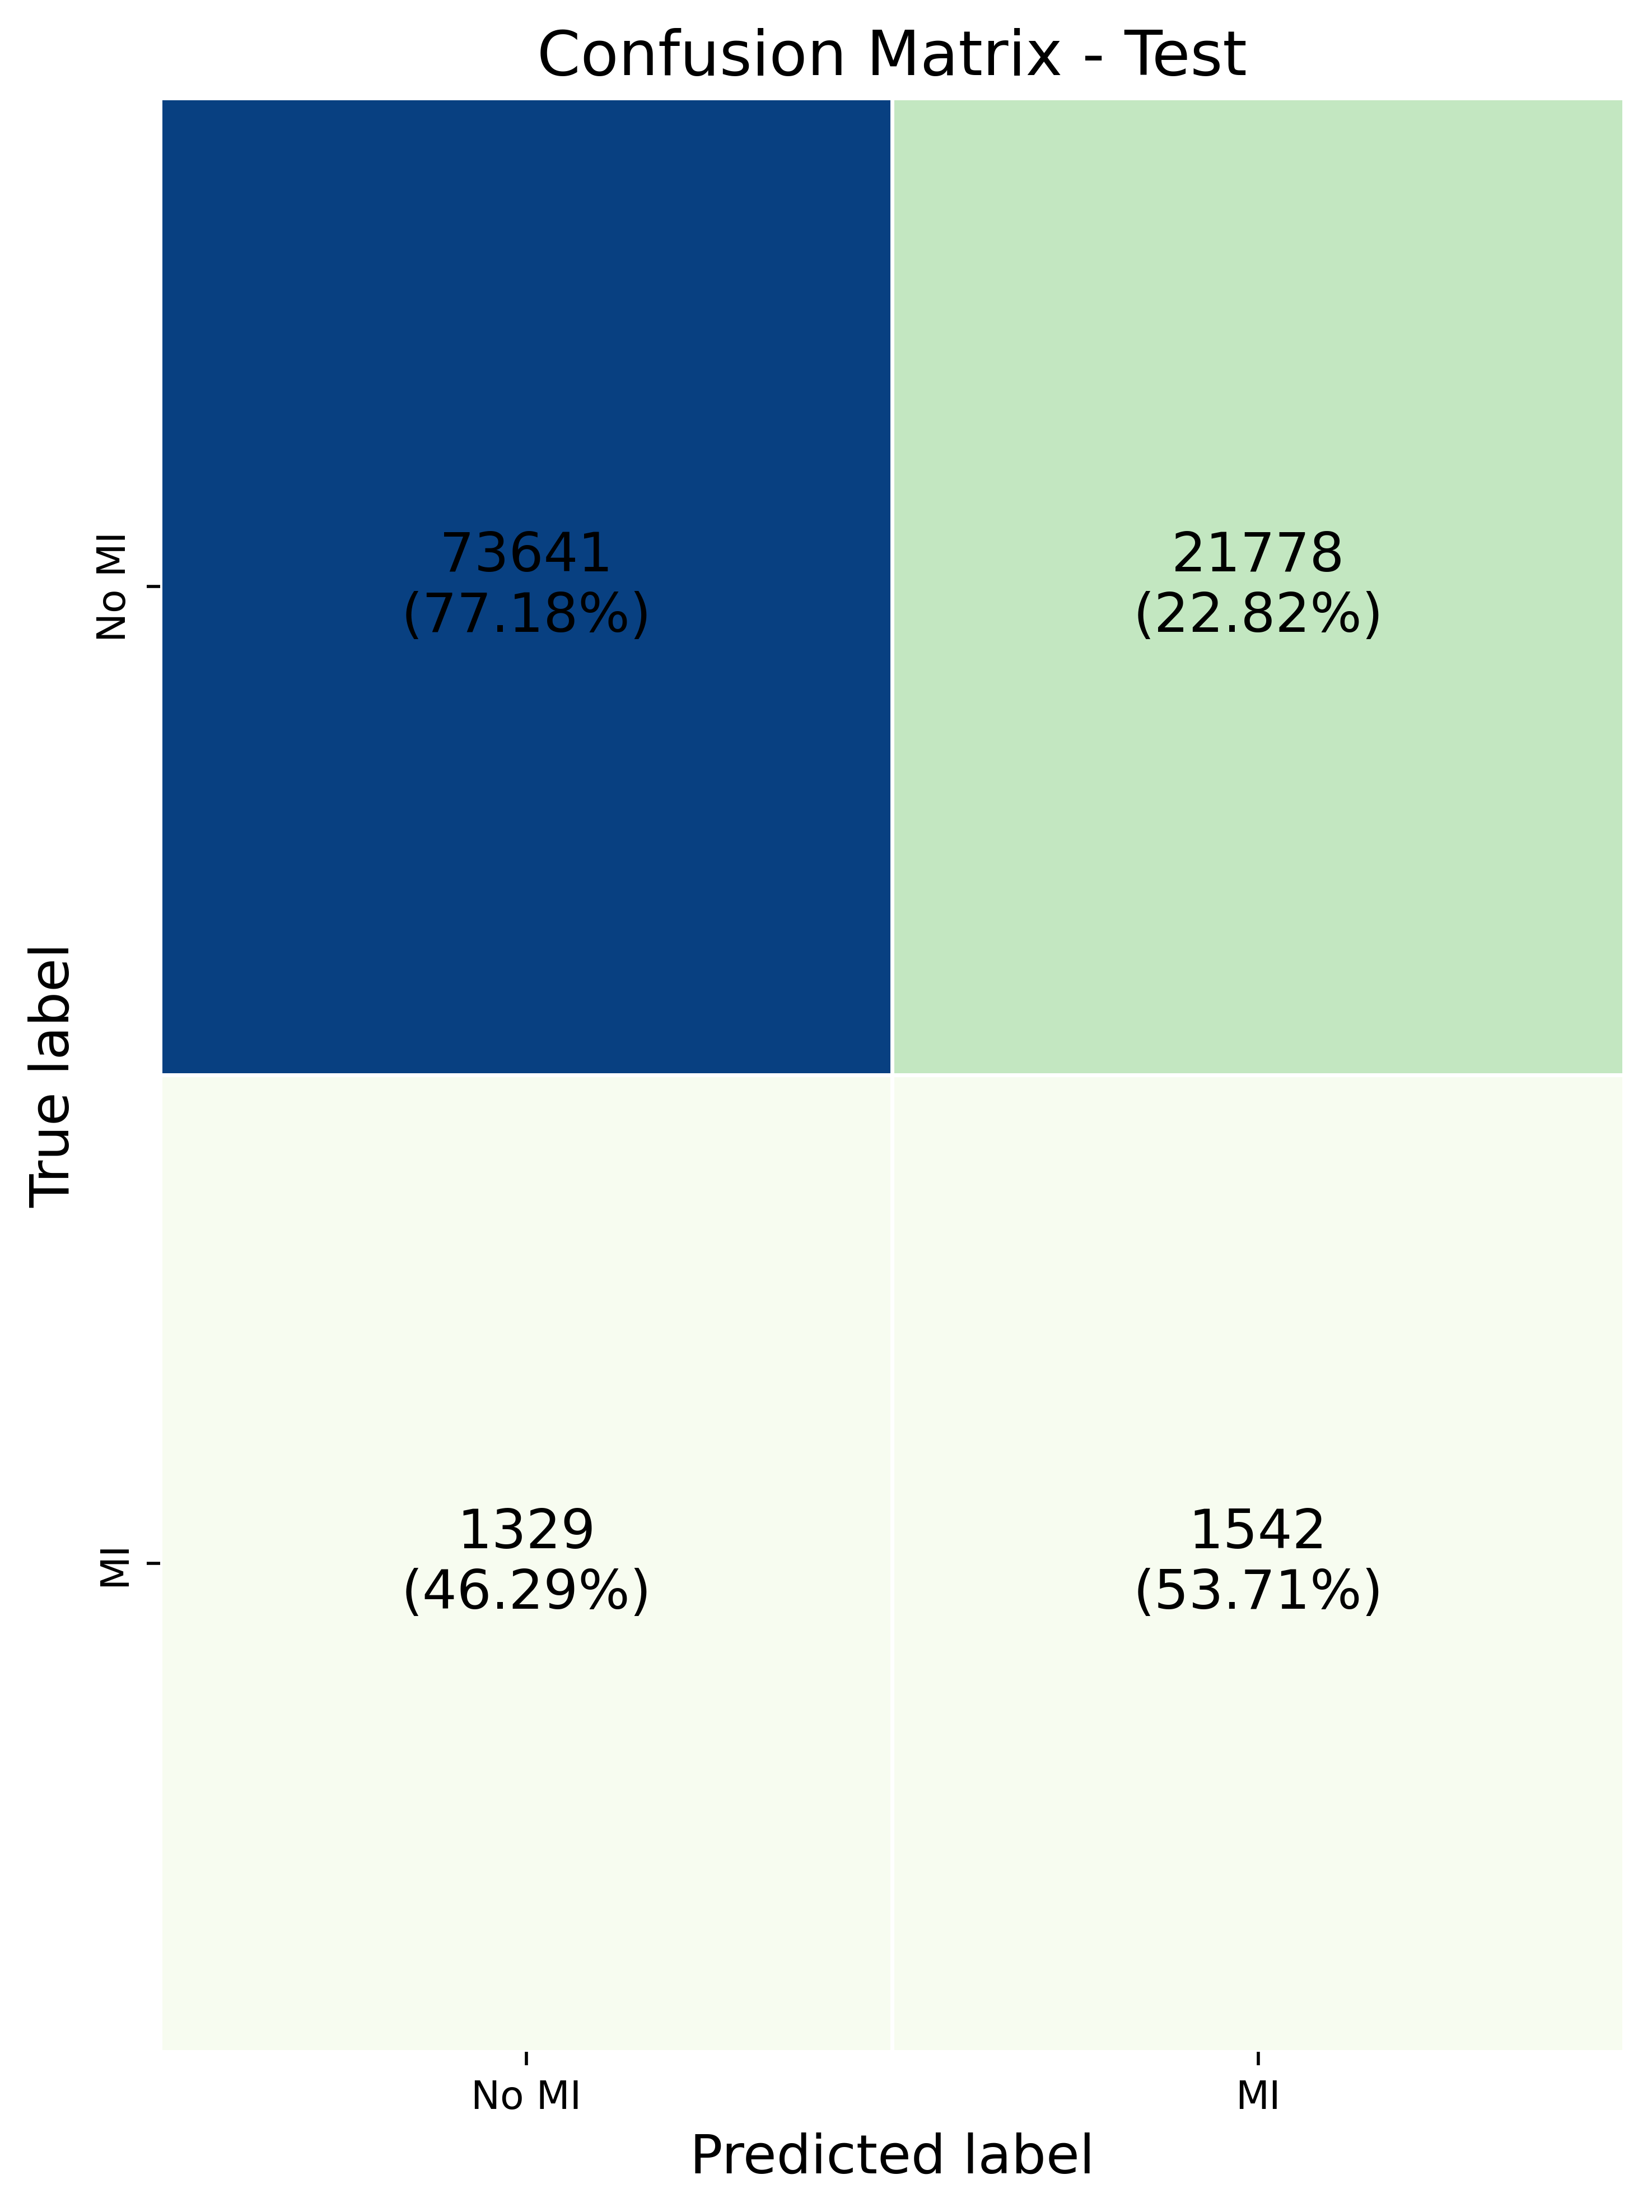

In [23]:
# Compute confusion matrix

# Make predictions
y_pred_proba = model.predict(dtest)
y_pred = [1 if y > threshold else 0 for y in y_pred_proba]

cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Initialize plot
plt.figure(figsize=(6, 8), dpi=500)

# Plot the heatmap
ax= sns.heatmap(cm, annot=False, cmap='GnBu', fmt='g', cbar=False,
                yticklabels=['No MI', 'MI'], 
                xticklabels=['No MI', 'MI'],
                linewidths=1,
                linecolor='white',
                annot_kws={'size':14, 'color':'black'})

# Add text annotations with percentage
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}\n({cm_percent[i, j]:.2f}%)',
                 ha='center', va='center', color='black', fontsize=14)


# Set axis labels and title
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=12)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix - Test', fontsize=16)

plt.tight_layout()
# plt.savefig('plot.png', 
#             format='png',
#             dpi=700,
#             transparent=True)
# Show plot
plt.show()


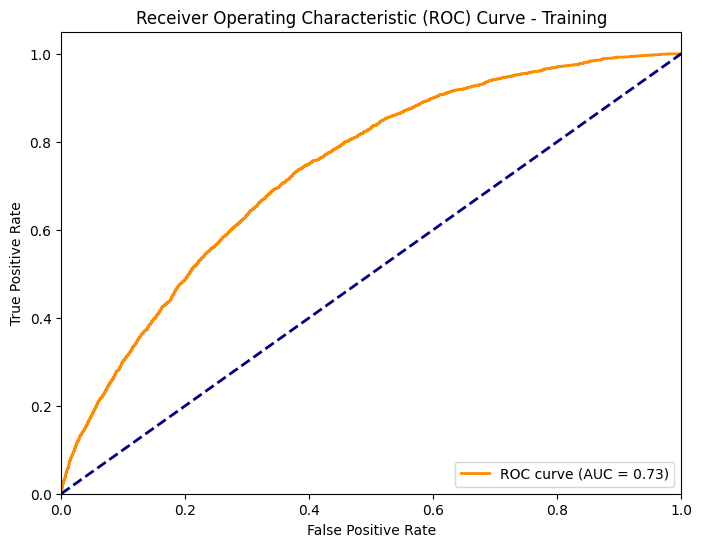

: 

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training')
plt.legend(loc="lower right")
plt.show()

In [15]:

# # Evaluate the model test
# print(f"Test")
# # Make predictions
# y_pred_proba = model.predict(dtest)
# y_pred = [1 if y > threshold else 0 for y in y_pred_proba]

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# label_size = {'size':18}
# plt.figure(figsize=(15, 10), dpi=500)
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Test', fontsize=16)
# plt.colorbar()
# tick_marks = np.arange(2)
# plt.xticks(tick_marks, ['No MI', 'MI'])
# plt.yticks(tick_marks, ['No MI', 'MI'])
# plt.ylabel('True label', fontdict=label_size)
# plt.xlabel('Predicted label', fontdict=label_size)
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
# plt.tight_layout()
# plt.savefig('plot.png', format='png',dpi=700)
# plt.show()

# # # ROC Curve
# # fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# # roc_auc = auc(fpr, tpr)
# # plt.figure(figsize=(20, 12), dpi=1200)
# # plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# # plt.xlim([0.0, 1.0])
# # plt.ylim([0.0, 1.05])
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('Receiver Operating Characteristic (ROC) Curve - Test')
# # plt.legend(loc="lower right")
# # plt.show()

# # print(classification_report(y_true=y_test,y_pred=y_pred))
# # print(cm)

## ***Shap***

In [9]:
explainer = shap.TreeExplainer(model)

In [10]:
# shap_value = explainer(dtrain)

In [ ]:
# shap.summary_plot(shap_value, max_display=30)

## ***Feature important***

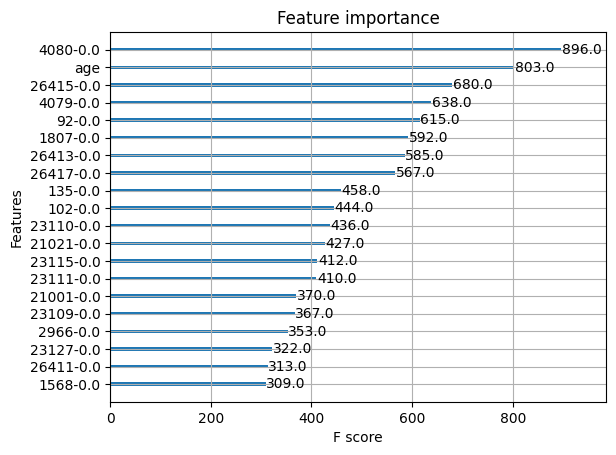

In [31]:
xgb.plot_importance(model, max_num_features=20)
plt.show()

In [ ]:
feature_names_df = pd.read_csv(r'../utilfiles/codes_after_reduction.csv')

feature_name_map = pd.Series(feature_names_df.description.values, index=feature_names_df.codes).to_dict()

def find_original_code(target_string,prefixes):
    for prefix in prefixes:
        if target_string.startswith(prefix):
            return prefix

def convert_feature_code_to_name(feature_code):
    code_founded = find_original_code(feature_code,feature_names)
    return feature_name_map.get(code_founded, code_founded) + ' - ' + code_founded

In [ ]:
RealFeatureNames = [convert_feature_code_to_name(code) for code in feature_names]

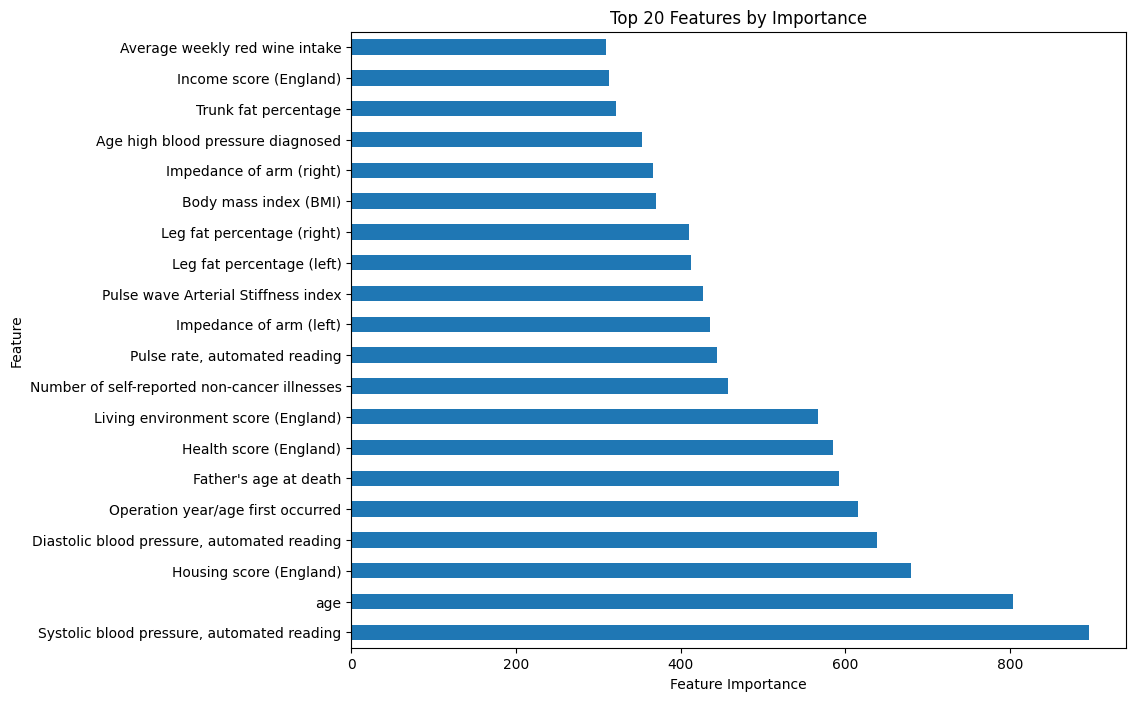

In [32]:
feature_names_df = pd.read_csv(r'../utilfiles/codes_after_reduction.csv')

# Create a dictionary for mapping feature codes to descriptions
feature_name_map = pd.Series(feature_names_df.description.values, index=feature_names_df.codes).to_dict()

# Function to map feature codes to their descriptions
def convert_feature_code_to_name(feature_code):
    return feature_name_map.get(feature_code, feature_code)

# Assuming 'model' is your trained XGBoost model
# Get the feature importance from the booster object
importances = model.get_score(importance_type='weight')

# Convert the importances to a pandas Series for easier handling
importances_series = pd.Series(importances)

# Sort by importance and take the top 20
top_20_features = importances_series.nlargest(20)

# Convert feature codes to descriptive names
RealFeatureNames = [convert_feature_code_to_name(code) for code in top_20_features.index]

# Plotting the top 20 features with their real names
plt.figure(figsize=(10, 8))
top_20_features.index = RealFeatureNames  # Replace codes with actual feature names
top_20_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance')
plt.show()
